# NBA Shooting Analysis

This project aims to provide insight on the efficiency of a players shot selection relative to their location on the court. This analysis takes a detailed look at the shot selection and shot making abilities of Devin Booker.

Helpful links: 
    
https://docs.google.com/document/d/1auS9wpjX1ohI0j_3-kwutI23heA5cN6LAGtxWMMJ-Ps/edit 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interactive
import seaborn as sb
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

In [2]:
shot_data = glob.glob("/Users/coreyhuang/Documents/Data Science Stuff/NBA Shot Analysis/NBA shot log 16-17-regular season/Shot data/*.csv")
player__df = pd.read_csv("/Users/coreyhuang/Documents/Data Science Stuff/NBA Shot Analysis/NBA shot log 16-17-regular season/Player Regular 16-17 Stats.csv")
schedule_df = pd.read_csv("/Users/coreyhuang/Documents/Data Science Stuff/NBA Shot Analysis/NBA shot log 16-17-regular season/Game Schedule 16-17-Regular.csv")

In [3]:
shot_data_tmp = []
for csvfile in shot_data:
    df = pd.read_csv(csvfile)
    shot_data_tmp.append(df)

In [4]:
shot_df = pd.concat(shot_data_tmp, axis = 0, ignore_index = True)

In [5]:
# Remove NaN
shot_df = pd.DataFrame(shot_df)

shot_df = shot_df.dropna(subset=['location x'])
shot_df = shot_df.reset_index(drop=True)

In [6]:
shot_df.head()

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,time,date,shoot player,time from last shot,quarter,current shot outcome
0,NaN,PF,Yes,107.0,SCORED,PHX,Floating Jump Shot,2,SAC,252.0,0:51,2016-10-26,Jared Dudley,NaN,1,SCORED
1,SCORED,SG,Yes,254.0,MISSED,PHX,Jump Shot,3,SAC,56.0,1:14,2016-10-26,Devin Booker,23.0,1,MISSED
2,MISSED,C,Yes,52.0,SCORED,PHX,Cutting Dunk Shot,2,SAC,250.0,1:44,2016-10-26,Tyson Chandler,30.0,1,SCORED
3,SCORED,PG,Yes,241.0,MISSED,PHX,Pullup Jump Shot,2,SAC,359.0,2:16,2016-10-26,Eric Bledsoe,32.0,1,MISSED
4,MISSED,SG,Yes,225.0,MISSED,PHX,Jump Shot,3,SAC,447.0,2:40,2016-10-26,Devin Booker,24.0,1,MISSED


## Create Basketball Court

In [7]:
def create_court(ax, color):
    # Short corner 3-pt line
    ax.plot([30, 30], [0, 140], linewidth=2, color=color)
    ax.plot([470, 470], [0, 140], linewidth=2, color=color)
    
    # 3-pt Arc
    ax.add_artist(mpl.patches.Arc((250, 140), 440, 315, theta1=0, theta2=180, 
                                  facecolor='none', edgecolor=color, lw=2))
    
    # Lane and Key
    ax.plot([170, 170], [0, 190], linewidth=2, color=color)
    ax.plot([330, 330], [0, 190], linewidth=2, color=color)
    ax.plot([190, 190], [0, 190], linewidth=2, color=color)
    ax.plot([310, 310], [0, 190], linewidth=2, color=color)
    ax.plot([170, 330], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((250, 190), 60, facecolor='none', edgecolor=color, lw=2))
    
    # Rim
    ax.add_artist(mpl.patches.Circle((250, 60), 15, facecolor='none', edgecolor=color, lw=2))
    
    # Backboard
    ax.plot([220, 280], [40, 40], linewidth=2, color=color)
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(0, 500)
    ax.set_ylim(0, 470)

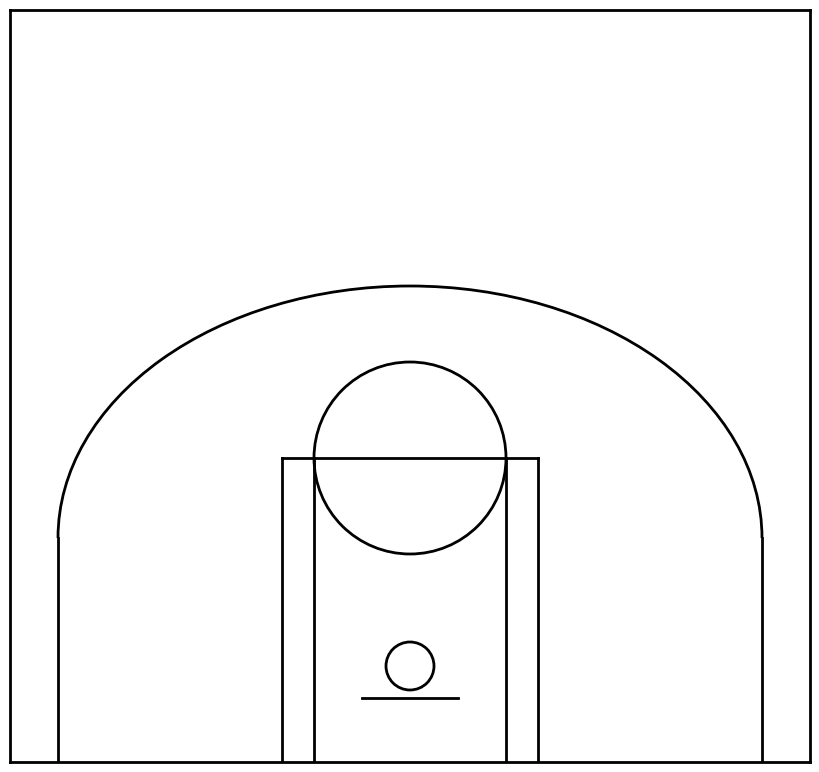

In [8]:
# General plot parameters
mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 1
mpl.rcParams['axes.linewidth'] = 2

# Draw basketball court
fig = plt.figure(figsize=(8, 7.52))
ax = fig.add_axes([0, 0, 1, 1])

create_court(ax, 'black')
plt.show()

## Modify Data Frame to Plot on a Halfcourt

In [9]:
## Create new dataframe for a HALFCOURT heat map:
# Copy shot_df, swap location x and y columns
clean_df_tmp= shot_df.copy()
clean_df_tmp.rename(columns={'location x':'location y', 'location y':'location x'}, inplace=True)
clean_df= clean_df_tmp.copy()

### Data Cleaning to fix misspelled 'shot type' values

In [10]:
# Copy column into new column
clean_df['shot type 2'] = clean_df['shot type']

# Define a list of correct play types
correct_shot_types = ['Jump Shot', 'Floating Jump Shot', 'Jump Bank Shot',
       'Turnaround Jump Shot', 'Running Dunk', 'Layup', 'Running Layup',
       'Driving Layup', 'Alley Oop Layup', 'Pullup Jump Shot',
       'Turnaround Fadeaway Shot', 'Step Back Jump Shot',
       'Fadeaway Jumper', 'Driving Floating Bank Jump Shot',
       'Driving Bank Shot', 'Driving Floating Jump Shot',
       'Running Pull-Up Jump Shot', 'Running Jump Shot', 'Putback Layup',
       'Driving Finger Roll Layup', 'Driving Bank Hook Shot',
       'Reverse Layup', 'Cutting Finger Roll Layup Shot', 'Dunk',
       'Pullup Bank Shot', 'Driving Reverse Layup',
       'Running Reverse Layup', 'Tip Layup Shot', 'Cutting Layup Shot',
       'Cutting Dunk Shot', 'Driving Dunk',
       'Running Alley Oop Layup Shot', 'Alley Oop Dunk', 'Hook Shot',
       'Fadeaway Bank Shot', 'Turnaround Fadeaway',
       'Turnaround Fadeaway Bank Jump Shot', 'Turnaround Bank Shot',
       'Driving Hook Shot', 'Finger Roll Layup']

# Define a function to remove player names from the play types
def clean_shot_type(shot_type):
    for shot in ["Peace", "Jr.", "Jones", "III", "I", "II", "IV", "Morris", "ris", "Mounte", "oute", "ce", 
                 "Peace", "V", "M", "a ", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0"]:
        shot_type = shot_type.replace(shot, "").strip()
    return shot_type

# Apply the clean_play_type function to the play_type column
clean_df["shot type 2"] = clean_df["shot type 2"].apply(clean_shot_type)

# Strip spaces and commas
clean_df["shot type 2"] = [element.replace(',', '').replace("'", '').strip() for element in clean_df["shot type 2"]]

### Combine similar shot types into one value

There may be too many different shot type classes that overcomplicate the data. For example, 'Turnaround Fadeaway Bank Jump Shot' and 'Turnaround Fadeaway' are very similar shot types. Since we are trying to examine the more general type of shot (jump shot, layup, dunk, etc), it will be more useful to combine similar shot types to improve the accuracy of predictions in the model. 

In [11]:
# Combine shot types

hook_shots = ['Driving Bank Hook Shot', 'Hook Shot', 'Driving Hook Shot']
jump_shots = ['Jump Shot', 'Jump Bank Shot', 'Pullup Jump Shot', 'Step Back Jump Shot',
             'Running Pull-Up Jump Shot', 'Running Jump Shot', 'Pullup Bank Shot',
            'Fadeaway Jumper', 'Fadeaway Bank Shot']
fadeaway_jump_shots = ['Turnaround Jump Shot', 'Turnaround Fadeaway', 'Turnaround Bank Shot', 
                       'Turnaround Fadeaway Bank Jump Shot', 'Turnaround Fadeaway Shot']
layups = ['Layup', 'Running Layup', 'Driving Layup', 'Alley Oop Layup', 'Driving Bank Shot', 'Putback Layup',
       'Driving Finger Roll Layup', 'Reverse Layup', 'Cutting Finger Roll Layup Shot', 'Driving Reverse Layup',
       'Running Reverse Layup', 'Tip Layup Shot', 'Cutting Layup Shot', 'Running Alley Oop Layup Shot', 
          'Finger Roll Layup']
floaters = ['Floating Jump Shot', 'Driving Floating Bank Jump Shot', 'Driving Floating Jump Shot']
dunks = ['Running Dunk',  'Dunk', 'Cutting Dunk Shot', 'Driving Dunk', 'Alley Oop Dunk']

clean_df['shot type 3'] = clean_df['shot type 2'].map(
    lambda x: 'Hook Shot' if x in ['Driving Bank Hook Shot', 'Hook Shot', 'Driving Hook Shot'] 
    else 'Jumper' if x in ['Jump Shot', 'Jump Bank Shot', 'Pullup Jump Shot', 'Step Back Jump Shot',
             'Running Pull-Up Jump Shot', 'Running Jump Shot', 'Pullup Bank Shot',
            'Fadeaway Jumper', 'Fadeaway Bank Shot'] 
    else 'Fadeaway' if x in ['Turnaround Jump Shot', 'Turnaround Fadeaway', 'Turnaround Bank Shot', 
                       'Turnaround Fadeaway Bank Jump Shot', 'Turnaround Fadeaway Shot']
    else 'Layup/Dunk' if x in ['Layup', 'Running Layup', 'Driving Layup', 'Alley Oop Layup', 'Driving Bank Shot', 'Putback Layup',
       'Driving Finger Roll Layup', 'Reverse Layup', 'Cutting Finger Roll Layup Shot', 'Driving Reverse Layup',
       'Running Reverse Layup', 'Tip Layup Shot', 'Cutting Layup Shot', 'Running Alley Oop Layup Shot', 
          'Finger Roll Layup', 'Running Dunk',  'Dunk', 'Cutting Dunk Shot', 'Driving Dunk', 'Alley Oop Dunk']
    else 'Floater' if x in ['Floating Jump Shot', 'Driving Floating Bank Jump Shot', 'Driving Floating Jump Shot']
    else x)

In [12]:
# Reorder columns
clean_df = clean_df[['location x', 'location y', 'shot type 3', 'shot type 2', 'self previous shot', 'player position', 'home game',
                         'opponent previous shot', 'home team', 'points', 'away team', 'time', 'date', 'shoot player',
                         'time from last shot', 'quarter', 'current shot outcome', 'shot type']]

In [13]:
# Create functions to rescale location for half-court diagram
def change_y(num):
    if num > 470:
        num = 940 - num
        return num
    else:
        return num

def change_x(num):
    if num < 250:
        num = 500 - num
        return num
    elif num > 250:
        num = 500 - num
        return num
    else:
        return num
    
# Update x and y coordinates
clean_df['location y'] = clean_df['location y'].apply(change_y)
clean_df['location x'] = clean_df['location x'].apply(change_x)

## Shots Attempted vs. Shots Made Heat Map

This heat map shows the distribution of shots in different areas on the court.

In [14]:
# Function that creates a new dataframe based on the player selected
def filter_player(player):
    new_df = clean_df.loc[clean_df['shoot player'] == player]
    return new_df

In [15]:
# Create dataframe for Devin Booker

# Shots attempted
dbook = filter_player('Devin Booker')

# Shots made
dbook_scored = dbook[dbook['current shot outcome'] == "SCORED"]

In [16]:
def heatmap(data, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="white", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):

    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    create_court(ax, 'white')
    
    x = data['location x']
    y = data['location y']
    
    sb.kdeplot(x=x, y=y, fill=True, cmap='inferno', ax=ax, **kwargs)

    ax.scatter(x=x, y=y, facecolors='w', s=2, linewidths=0.1, **kwargs)
    
    # Set the spines to match the rest of court lines, makes outer_lines

    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax

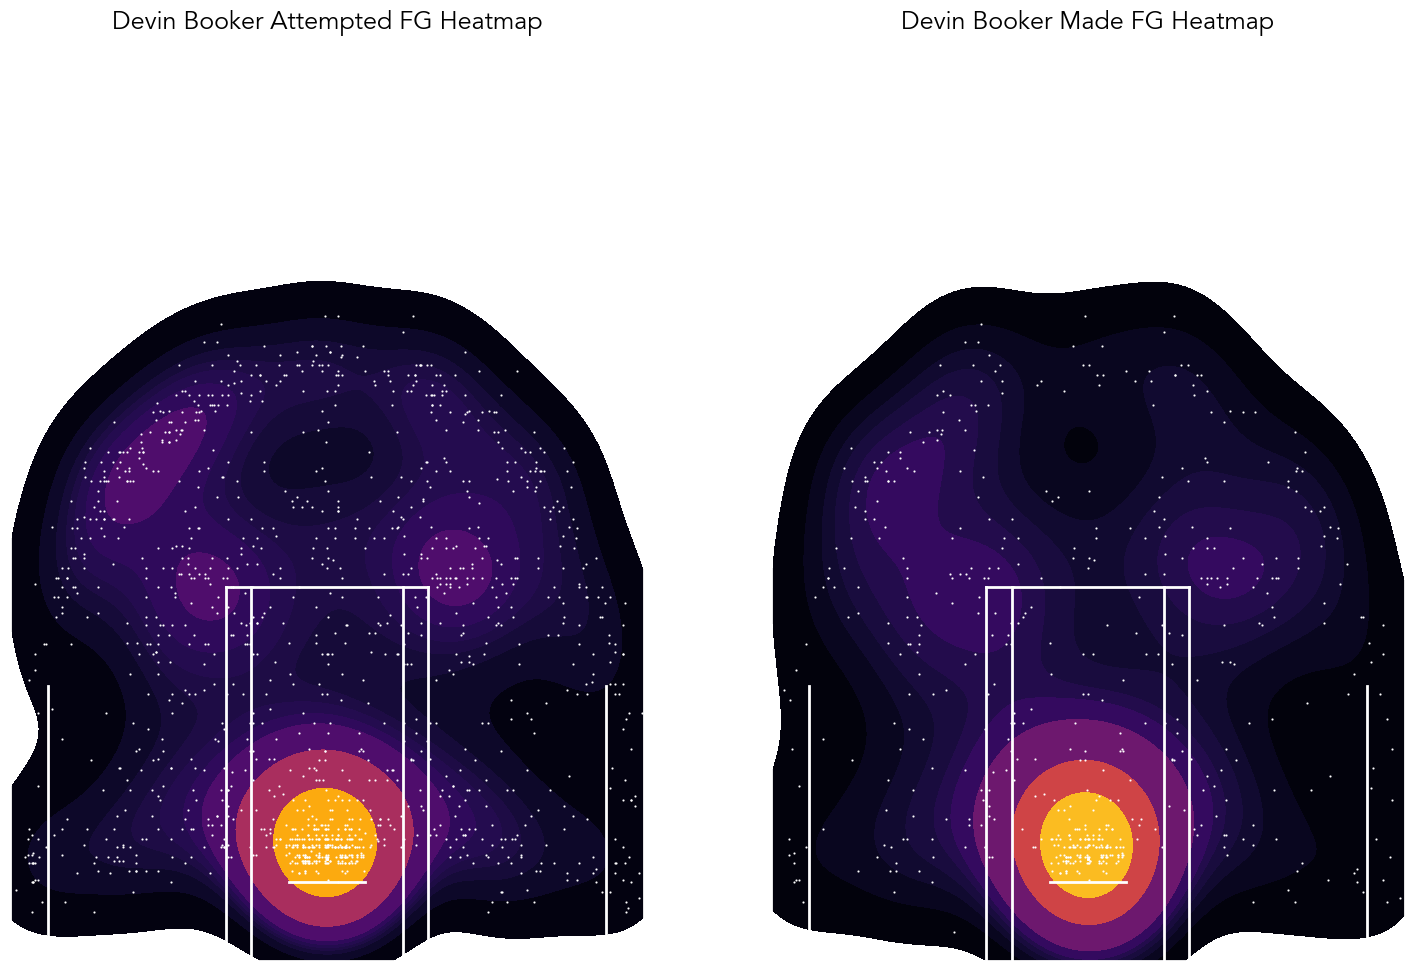

In [17]:
ax = fig.add_axes([0, 0, 1, 1])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,12))

heatmap(dbook, "Devin Booker Attempted FG Heatmap", ax=ax1)
heatmap(dbook_scored, "Devin Booker Made FG Heatmap", ax=ax2)
plt.show()

From the two heatmaps, we can see that Devin Booker makes less of his 3 point field goals at the top of the 3 point line compared to the sides of the arc. The same pattern is seen with his mid range shots. 

## K-Nearest Neighbors Algorithm

In this section, a K-Nearest Neighbors Classifier Analysis is conducted using Python's Scikit-Learn to determine what shot type a player will take based on their location on the court.

### Check for NaNs in the columns of interest

In [18]:
print("Number of NaNs in the columns of interest:", clean_df['shot type 3'].isnull().sum(), 
      clean_df['location x'].isnull().sum(), clean_df['location y'].isnull().sum())

Number of NaNs in the columns of interest: 0 0 0


### Visual plot

To begin the analysis, a scatterplot of the different shot types are plotted to get a general sense of how the shot types are distributed. It can be seen that jump shots are generally taken outside of the paint area, while floaters and hook shots are taken in the paint. Layups and dunks are taken in the restricted area while fadeaways are taken on the outskirts of the paint and in the midrange.

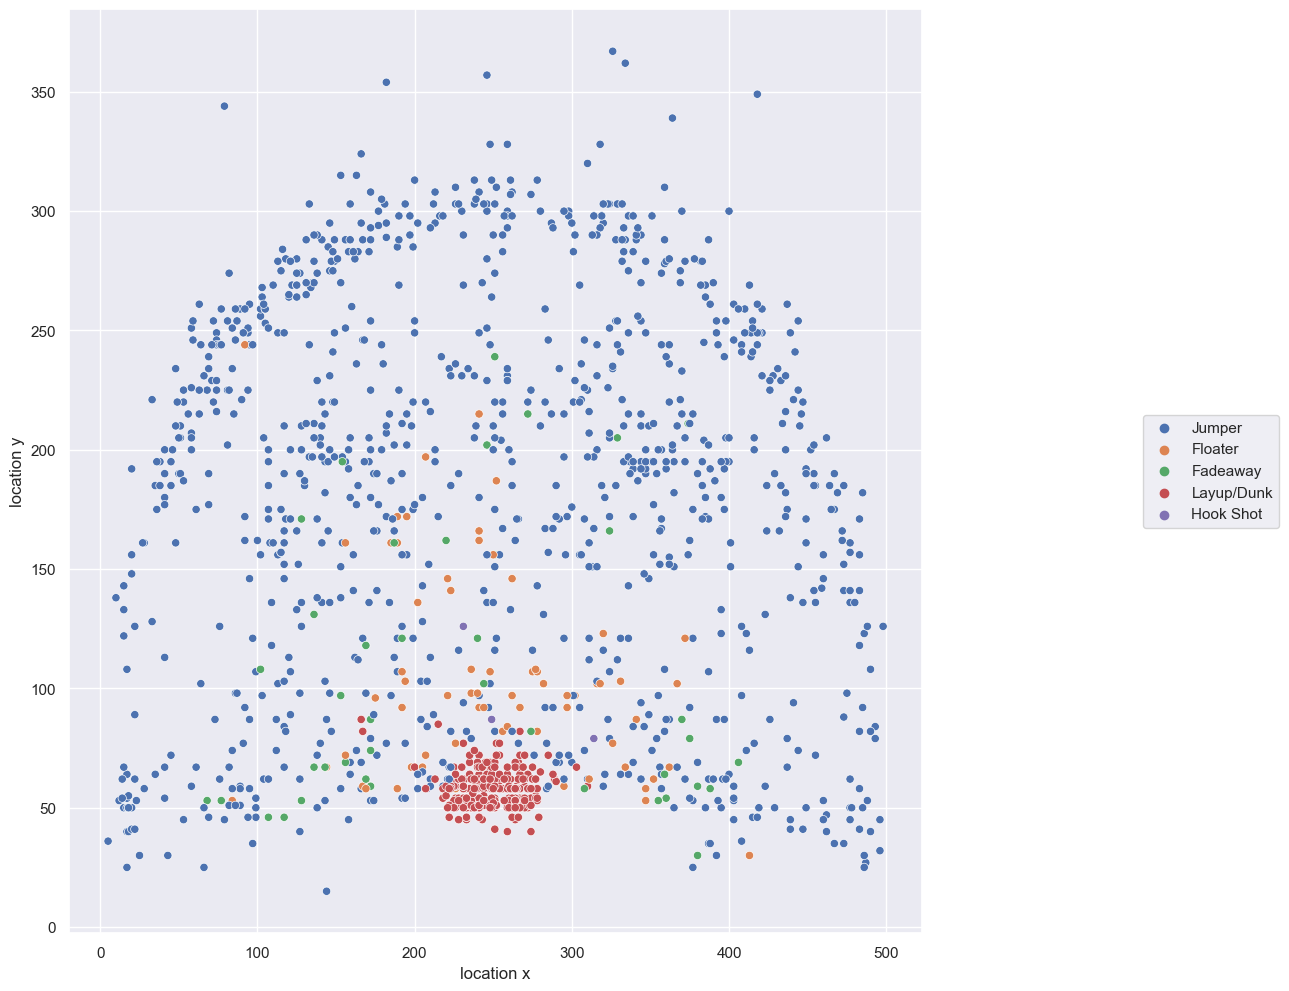

In [19]:
sb.set(rc={'figure.figsize':(11,12)})
g = sb.scatterplot(x=dbook['location x'],y=dbook['location y'], hue=dbook['shot type 3'])
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

### Split data into training and testing

In [20]:
X = dbook.iloc[:,0:2]
y = dbook.iloc[:, 2]

# Perform Oversampling
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

oversampler = RandomOverSampler(random_state=50)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

In [21]:
y_train_resampled

0           Jumper
1          Floater
2           Jumper
3           Jumper
4           Jumper
           ...    
3685    Layup/Dunk
3686    Layup/Dunk
3687    Layup/Dunk
3688    Layup/Dunk
3689    Layup/Dunk
Name: shot type 3, Length: 3690, dtype: object

Because both variables 'location x' and 'location y' are measured by feet, there is no reason to scale the two variables.

### Find K

In [22]:
# Find K value
import math
num = math.sqrt(len(y_train_resampled))
print(num)

60.74537019394976


In [23]:
k = 12

### Fit Model

In [24]:
classifier = KNeighborsClassifier(n_neighbors=k, p=2, metric='euclidean')

In [25]:
# Fit Model
classifier.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(metric='euclidean', n_neighbors=12)

In [26]:
# Predict the test set results
y_pred = classifier.predict(X_test)

## Evaluation of Model

### Confusion Matrix

In [27]:
labels = ['Hook Shot', 'Floater', 'Fadeaway', 'Jumper', 'Layup/Dunk']
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print("True outcomes (side) vs. Predicted outcomes (top)")
print(cm_df)

True outcomes (side) vs. Predicted outcomes (top)
            Hook Shot  Floater  Fadeaway  Jumper  Layup/Dunk
Hook Shot           3        3         0       2           1
Floater             1       14         0       1           3
Fadeaway            0        2         0       0           0
Jumper             39       27         1     182           5
Layup/Dunk          0        1         1       0          66


### F1 Score

In [28]:
print(f1_score(y_test, y_pred, average="macro"))

0.4583722276205192


### Precision and Recall Scores

In [29]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("Precision Score: ", precision)
print("Recall Score: ", recall)

Precision Score:  0.8977515980849727
Recall Score:  0.7528409090909091


### Results

A precision score of 0.90 is a strong indicator of an accurate model, as it means that the model correctly identified 90% of the positive predictions correctly. Additionally, a recall score of 0.75 indicates that the model correctly predicted 75% of all the positive cases in the model. This model is best utilized for finding general shooting preferences of selected opponents to create defensive strategies to counter their playstyle. This model can also be specified to include how a player's shooting preference changes depending on the specific team for a more accurate analysis of their shooting profile. 